In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

# Standard Imports
%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import scipy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import os
import glob
import seaborn as sns
import warnings
import datetime
warnings.simplefilter(action='ignore', category=FutureWarning)

# ESIO Imports

from esio import EsioData as ed
from esio import import_data
from esio import ice_plot

In [2]:
# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
E = ed.EsioData.load()
# Directories
all_models=['awispin']
runType='forecast'
updateall = False

In [4]:
stero_grid_file = E.obs['NSIDC_0051']['grid']
obs_grid = import_data.load_grid_info(stero_grid_file, model='NSIDC')
# Ensure latitude is within bounds (-90 to 90)
# Have to do this because grid file has 90.000001
obs_grid['lat_b'] = obs_grid.lat_b.where(obs_grid.lat_b < 90, other = 90)

In [5]:
# Regridding Options
method='nearest_s2d' # ['bilinear', 'conservative', 'nearest_s2d', 'nearest_d2s', 'patch']

In [6]:
## TODO
# - Get mask
# - Get lat lon bounds 

In [7]:
var_dic = {'y':'nj','x':'ni','ice_concn':'sic'}

In [8]:
cyear = '2018' # TODO hardcode
actual_year = int(cyear)

In [9]:
mon_dic = {'jun':'06','jul':'07','aug':'08'}

In [10]:
def preprocess_awi_time(ds=None, actual_year=None):
    
    ds = ds.rename({'time':'valid_time'})
    
    # Round off to nearest hour
    ds.coords['valid_time'] = ds.coords['valid_time'].values + np.timedelta64(1, 'm')
    ds.coords['valid_time'] = np.array(ds.valid_time.values, dtype='datetime64[h]').astype('datetime64[ns]')

    ds.coords['init_time'] = ds.valid_time.values[0]      
    ds.coords['fore_time'] = (ds.valid_time - ds.init_time)
    ds = ds.swap_dims({'valid_time':'fore_time'})
    ds = ds.drop('valid_time')

    # Make dates current year
    sanedate = pd.to_datetime(pd.to_datetime(ds.init_time.item()))
    ds.coords['init_time'] = datetime.datetime(actual_year,sanedate.month,sanedate.day)
    
    return ds

In [11]:
for model in all_models:
    print('Regridding ', model, '...')
    
    data_dir = os.path.join('/home/disk/sipn/upload',model,runType) 
    data_out = E.model[model][runType]['sipn_nc']
    model_grid_file = E.model[model]['grid']
    
    # Files are stored as one per month, average of ensemble
    prefix = 'ice_concn'
    
    # Get list of dir ("months")
    mon_dirs = [ name for name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, name)) ]
    print(mon_dirs)

    print("Found ",len(mon_dirs)," months.")
    if updateall:
        print("Updating all files...")
    else:
        print("Only updating new files")
    
    # for each  month
    for cmon in mon_dirs:
        
        # Check if already imported and skip (unless updateall flag is True)
        f_out = os.path.join(data_out, cyear+'_'+mon_dic[cmon]+'_Stereo.nc') # netcdf file out 
        if not updateall:
            # TODO: Test if the file is openable (not corrupted)
            if os.path.isfile(f_out):
                print("Skipping ", os.path.basename(f_out), " already imported.")
                continue # Skip, file already imported
         
        all_files = sorted(glob.glob(os.path.join(data_dir, cmon, prefix+'*nsidc25km.nc'), recursive=True))

        ds = xr.open_mfdataset(all_files, concat_dim='ensemble', preprocess=lambda x: preprocess_awi_time(ds=x, actual_year=actual_year))
        ds.coords['ensemble'] = np.arange(1,ds.ensemble.size+1,1)

        # Rename variables per esipn guidelines
        ds.rename(var_dic, inplace=True);
        
        ds = ds.drop(['lon_bnds','lat_bnds'])
    
        # radians to deg
        ds['lat'] = np.rad2deg(ds.lat)
        ds['lon'] = np.rad2deg(ds.lon)

        # Expand dims
        ds_out = import_data.expand_to_sipn_dims(ds)

        # # Save regridded to netcdf file
        ds_out.to_netcdf(f_out)
        ds_out = None # Memory clean up
        ds = None
        print('Saved ', f_out)
        

Regridding  awispin ...
['jun', 'jul', 'aug']
Found  3  months.
Only updating new files
Skipping  2018_06_Stereo.nc  already imported.
Skipping  2018_07_Stereo.nc  already imported.
Skipping  2018_08_Stereo.nc  already imported.


# Plotting

In [14]:
sic_all = xr.open_mfdataset('/home/disk/sipn/nicway/data/model/awispin/forecast/sipn_nc/2018_08_Stereo.nc')
sic_all.init_time

<xarray.DataArray 'init_time' (init_time: 1)>
array(['2018-08-13T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * init_time  (init_time) datetime64[ns] 2018-08-13

Text(0.5,1,'Target Grid')

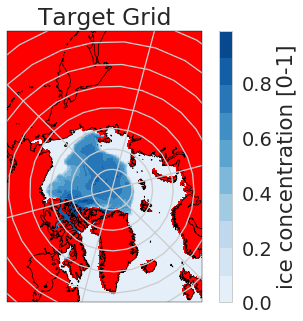

In [15]:


# Set up plotting info
cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10))
cmap_sic.set_bad(color = 'red')

# Plot SIC on target projection
(f, ax1) = ice_plot.polar_axis()
ds_p2 = sic_all.sic.isel(init_time=0).isel(fore_time=10).isel(ensemble=0)
ds_p2.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_sic)
ax1.set_title('Target Grid')
